# BERT from Scratch: Complete Tutorial for Google Colab

Welcome to this comprehensive tutorial on building BERT (Bidirectional Encoder Representations from Transformers) from scratch! This notebook is optimized for **Google Colab with T4 GPU**.

## 🚀 Quick Setup for Colab
1. Go to **Runtime → Change runtime type**
2. Set **Hardware accelerator** to **GPU** (T4)
3. Click **Save**
4. Run all cells sequentially!

## What You'll Build:
- Complete BERT architecture from scratch
- Masked Language Modeling (MLM) and Next Sentence Prediction (NSP)
- Bidirectional attention mechanism
- Pre-training and fine-tuning strategies
- All components explained step-by-step

## Key Differences: BERT vs GPT-2
| Feature | BERT | GPT-2 |
|---------|------|-------|
| Architecture | Encoder-only | Decoder-only |
| Attention | Bidirectional | Causal (unidirectional) |
| Training | MLM + NSP | Next token prediction |
| Use Case | Understanding | Generation |

## Table of Contents
- [Environment Setup](#environment-setup)
- [Architecture Overview](#architecture-overview)
- [Token & Position Embeddings](#embeddings)
- [Bidirectional Attention](#attention)
- [Feed-Forward Networks](#ffn)
- [Transformer Encoder](#encoder)
- [Complete BERT Model](#complete-model)
- [Pre-training Tasks](#pretraining)
- [Fine-tuning](#finetuning)
- [Performance Testing](#performance)

In [21]:
# Environment Setup for Google Colab
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import random

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"GPU: {gpu_name}")
    print(f"GPU Memory: {gpu_memory:.1f} GB")
    
    # Enable optimizations for T4
    torch.backends.cudnn.benchmark = True
    torch.cuda.empty_cache()
else:
    print("GPU not available. Switch to GPU runtime!")

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(42)
print("Environment setup complete!")

Using device: cuda
GPU: NVIDIA GeForce GTX 1050 Ti
GPU Memory: 4.2 GB
Environment setup complete!


## 🧠 BERT Architecture Overview

**BERT (Bidirectional Encoder Representations from Transformers)** is an **encoder-only Transformer** architecture designed for **natural language understanding (NLU)** tasks.  
It achieves state-of-the-art performance across multiple benchmarks by leveraging deep bidirectional attention and large-scale unsupervised pre-training.

---

### 🔍 Key Innovations

1. **Bidirectional Self-Attention**  
   Unlike left-to-right models (e.g., GPT), BERT jointly attends to **both left and right context** in all layers, allowing richer contextual understanding.

2. **Masked Language Modeling (MLM)**  
   Randomly masks a subset of input tokens and trains the model to **predict the original tokens** based on surrounding context.

3. **Next Sentence Prediction (NSP)**  
   A binary classification task that helps BERT learn **inter-sentence relationships**, improving performance on QA and entailment tasks.

4. **Pre-train → Fine-tune Paradigm**  
   BERT is **pre-trained** on massive unlabeled corpora (BooksCorpus + Wikipedia) and later **fine-tuned** on specific downstream tasks with minimal task-specific architecture changes.

---

### 🏗️ Architectural Components

**Input Pipeline:**
$ Input Text → Tokenization → Embeddings (Token + Segment + Position) $

**Model Stack:**
$ Embeddings → Transformer Encoder Blocks (×12 for BERT-Base) $


**Output Heads:**
- **[CLS] token** → Sentence-level tasks (e.g., classification, entailment)  
- **All token embeddings** → Token-level tasks (e.g., NER, QA)

---

<div align="center">
  <img src="https://en.wikipedia.org/wiki/BERT_(language_model)#/media/File:BERT_embeddings_01.png" 
       alt="BERT model architecture diagram" width="600"/>

  <p><em>Figure: Simplified BERT architecture overview (Source: Wikimedia, CC BY-SA 4.0)</em></p>
</div>

---

### ⚙️ Model Configurations

| Model Variant | Layers | Hidden Size | Attention Heads | Parameters |
|----------------|---------|--------------|------------------|-------------|
| **BERT-Base**  | 12      | 768          | 12               | ~110M       |
| **BERT-Large** | 24      | 1024         | 16               | ~340M       |

---

### 🧮 Mathematical Intuition

#### Masked Language Modeling (MLM)

<div align="center">
  <img src="https://en.wikipedia.org/wiki/BERT_(language_model)#/media/File:BERT_masked_language_modelling_task.png" 
       alt="Masked Language Modeling" width="600"/>

  <p><em>Figure: Masked Language Modeling Task (Source: Wikimedia, CC BY-SA 4.0)</em></p>
</div>

Given an input token sequence $ x = (x_1, x_2, …, x_N) $, we mask a subset of positions $ M \subset \{1,…,N\} $ and replace those tokens with a special $[MASK]$ token (or sometimes a random token or remain unchanged) during pre-training. The model outputs contextualized representations and then computes a softmax over the vocabulary for each masked position $ i \in M $. The loss is:

$$
\mathcal{L}_{\text{MLM}} = - \frac{1}{|M|} \sum_{i \in M} \log \; P( x_i \mid x_{\setminus M} )
$$

where $ x_{\setminus M} $ denotes the input sequence with masked positions.  
The training objective is to maximise the probability of the true token at each masked position.

#### Next Sentence Prediction (NSP) 

<div align="center">
  <img src="https://en.wikipedia.org/wiki/BERT_(language_model)#/media/File:BERT_next_sequence_prediction_task.png" 
       alt="Next Sentence Prediction" width="600"/>

  <p><em>Figure: Next Sentence Prediction (Source: Wikimedia, CC BY-SA 4.0)</em></p>
</div>

Given a pair of sentences $ (A, B) $, the model receives the tokenized input:
$ [CLS] … tokens of A … [SEP] … tokens of B … [SEP] $

and produces an embedding for the $ [CLS] $ token, say $ h_{\text{CLS}} $. A binary classifier atop $ h_{\text{CLS}} $ predicts whether B follows A (label = 1) or not (label = 0). The loss is:

$$
\mathcal{L}_{\text{NSP}} = - \frac{1}{2} \Big( \log P(\text{IsNext} \mid h_{\text{CLS}}) + \log P(\text{NotNext} \mid h_{\text{CLS}}) \Big)
$$

In practice with a mini-batch this becomes the average negative log-likelihood over the sentence pair labels.

#### Combined Pre-training Loss

The total pre-training loss is a sum of the two objectives (ignoring other minor regularisation terms):

$$
\mathcal{L} = \mathcal{L}_{\text{MLM}} + \mathcal{L}_{\text{NSP}}
$$

By minimising $ \mathcal{L} $, the model simultaneously learns token-level bidirectional context (via MLM) and inter-sentence relationships (via NSP).

---

### 💡 Hardware Considerations (NVIDIA T4)

- **BERT-Base** can be trained comfortably on a single NVIDIA T4 GPU.  
- **BERT-Large** typically requires **gradient checkpointing** or **mixed-precision training** to fit GPU memory.  
- Despite bidirectional attention, BERT tends to be **more memory-efficient** than autoregressive models (e.g., GPT-2) for equivalent sequence length, because of encoder-only design and no autoregressive masking.

---

### 📚 Reference

Devlin, J., Chang, M.-W., Lee, K., & Toutanova, K. (2019).  
**BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding.**  
*Proceedings of NAACL-HLT*, 4171–4186.  
[https://arxiv.org/abs/1810.04805](https://arxiv.org/abs/1810.04805)

In [22]:
# Utility Functions
def get_model_size(model):
    """Calculate model size in parameters and memory."""
    param_count = sum(p.numel() for p in model.parameters())
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    total_size = param_size + buffer_size
    
    return {
        'parameters': param_count,
        'size_mb': total_size / 1e6,
        'size_gb': total_size / 1e9
    }

def check_gpu_memory():
    """Check GPU memory usage."""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1e9
        cached = torch.cuda.memory_reserved() / 1e9
        total = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f" GPU Memory - Allocated: {allocated:.2f}GB, Cached: {cached:.2f}GB, Total: {total:.1f}GB")
        return allocated, cached, total
    return 0, 0, 0

# Initial memory check
check_gpu_memory()

 GPU Memory - Allocated: 0.78GB, Cached: 0.84GB, Total: 4.2GB


(0.776302592, 0.843055104, 4.227465216)

## Token, Position & Segment Embeddings

BERT uses **three types of embeddings** that are summed together:

### 1. Token Embeddings
- Convert word pieces to vectors
- Vocabulary size: 30,522 (WordPiece tokenization)

### 2. Position Embeddings
- Learned positional encodings (not sinusoidal like original Transformer)
- Maximum sequence length: 512 tokens

### 3. Segment Embeddings
- Distinguish between sentence A and sentence B
- Used for tasks like NSP and QA
- Only 2 embeddings: [0, 1]

### Mathematical Formula:
$ E_{total} = E_{token} + E_{position} + E_{segment} $
### Special Tokens:
- **[CLS]**: Classification token (always first)
- **[SEP]**: Separator between sentences
- **[MASK]**: Masked token for MLM
- **[PAD]**: Padding token

In [23]:
class BERTEmbedding(nn.Module):
    """
    BERT Embedding: Token + Position + Segment embeddings.
    
    Args:
        vocab_size (int): Vocabulary size
        d_model (int): Embedding dimension
        max_seq_len (int): Maximum sequence length
        dropout (float): Dropout probability
    """
    def __init__(self, vocab_size, d_model, max_seq_len=512, dropout=0.1):
        super().__init__()
        
        # Token embeddings
        self.token_embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        
        # Position embeddings (learned, not sinusoidal)
        self.position_embedding = nn.Embedding(max_seq_len, d_model)
        
        # Segment embeddings (for sentence A/B)
        self.segment_embedding = nn.Embedding(2, d_model)
        
        # Layer normalization and dropout
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-12)
        self.dropout = nn.Dropout(dropout)
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        """Initialize embedding weights."""
        nn.init.normal_(self.token_embedding.weight, mean=0, std=0.02)
        nn.init.normal_(self.position_embedding.weight, mean=0, std=0.02)
        nn.init.normal_(self.segment_embedding.weight, mean=0, std=0.02)
        
    def forward(self, input_ids, segment_ids=None):
        """
        Args:
            input_ids: (batch_size, seq_len)
            segment_ids: (batch_size, seq_len) - optional, defaults to all 0s
        """
        batch_size, seq_len = input_ids.size()
        
        # Create position IDs
        position_ids = torch.arange(seq_len, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        
        # Default segment IDs if not provided
        if segment_ids is None:
            segment_ids = torch.zeros_like(input_ids)
        
        # Get embeddings
        token_emb = self.token_embedding(input_ids)
        position_emb = self.position_embedding(position_ids)
        segment_emb = self.segment_embedding(segment_ids)
        
        # Sum all embeddings
        embeddings = token_emb + position_emb + segment_emb
        
        # Apply layer norm and dropout
        embeddings = self.layer_norm(embeddings)
        embeddings = self.dropout(embeddings)
        
        return embeddings

# Test BERT embeddings
vocab_size = 30522  # BERT vocabulary size
d_model = 768       # BERT-Base hidden size
max_seq_len = 512

bert_embedding = BERTEmbedding(vocab_size, d_model, max_seq_len).to(device)

# Test with sample input
batch_size = 2
seq_len = 20
sample_input_ids = torch.randint(100, vocab_size-100, (batch_size, seq_len)).to(device)
sample_segment_ids = torch.cat([
    torch.zeros(batch_size, seq_len//2, dtype=torch.long),
    torch.ones(batch_size, seq_len//2, dtype=torch.long)
], dim=1).to(device)

embeddings = bert_embedding(sample_input_ids, sample_segment_ids)

print(f"BERT Embedding Test:")
print(f"Input IDs: {sample_input_ids.shape}")
print(f"Segment IDs: {sample_segment_ids.shape}")
print(f"Output embeddings: {embeddings.shape}")
print(f"Memory: {get_model_size(bert_embedding)['size_mb']:.1f}MB")

BERT Embedding Test:
Input IDs: torch.Size([2, 20])
Segment IDs: torch.Size([2, 20])
Output embeddings: torch.Size([2, 20, 768])
Memory: 95.3MB


## 🔁 Bidirectional Multi-Head Attention

Unlike GPT-2’s **causal attention**, BERT employs **bidirectional self-attention**, meaning that **each token attends to all other tokens** in the sequence — both to its left and right.  
This allows BERT to build deep contextual representations ideal for **language understanding** tasks.

---

### ⚖️ Key Differences from GPT-2

| Feature | **BERT (Bidirectional)** | **GPT-2 (Causal)** |
|----------|---------------------------|--------------------|
| **Attention Mask** | No causal mask → full visibility | Causal mask → only left context visible |
| **Context Access** | Sees entire sentence (past + future) | Sees only past tokens |
| **Use Case** | Understanding / classification tasks | Text generation / prediction |
| **Mask Type** | Padding mask only | Padding + causal mask |

✅ **Full-context modeling**  
✅ **Ignores padding tokens**  
❌ **No autoregressive constraint**

---

### 🎯 Attention Visualization

| GPT-2 (Causal) | BERT (Bidirectional) |
|:---------------:|:-------------------:|
| $\begin{bmatrix}1 & 0 & 0 & 0 \\ 1 & 1 & 0 & 0 \\ 1 & 1 & 1 & 0 \\ 1 & 1 & 1 & 1 \end{bmatrix} $ | $ \begin{bmatrix}1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 \end{bmatrix} $ |

Each matrix entry $ M_{ij} $ indicates whether token $ i $ can attend to token $ j $.  
- GPT-2 applies a **lower-triangular causal mask** → only previous tokens visible.  
- BERT applies a **full mask** → every token can attend to every other token.

---

### 🧮 Mathematical Formulation

**Scaled Dot-Product Attention:**
$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right)V
$$

where  
- $ Q, K, V $ = query, key, and value matrices derived from input embeddings,  
- $ d_k $ = key dimensionality.

**Multi-Head Attention:**

$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h) W^O
$$
$$
\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)
$$

This allows BERT to learn multiple attention “views” of the same input (e.g., syntactic vs. semantic).

---

### 🧠 Why Bidirectional Attention Matters

- **Deep Language Understanding:** Enables simultaneous access to *past and future* context → essential for tasks like sentence classification and natural language inference.  
- **Masked Token Prediction (MLM):** Predicts masked tokens using *both* left and right contexts.  
- **Sentence Relationship Tasks (NSP):** Learns inter-sentence coherence by seeing full sentence pairs.

---

### 📚 References

- Vaswani, A. et al. (2017). *Attention Is All You Need.* NeurIPS.  
- Devlin, J., Chang, M.-W., Lee, K., & Toutanova, K. (2019). *BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding.*  
  [https://arxiv.org/abs/1810.04805](https://arxiv.org/abs/1810.04805)


   Multi-Head Attention Test:
   Input: torch.Size([2, 10, 768])
   Attention mask: torch.Size([2, 10])
   Output: torch.Size([2, 10, 768])
   Attention weights: torch.Size([2, 12, 10, 10])
   Parameters: 2,362,368


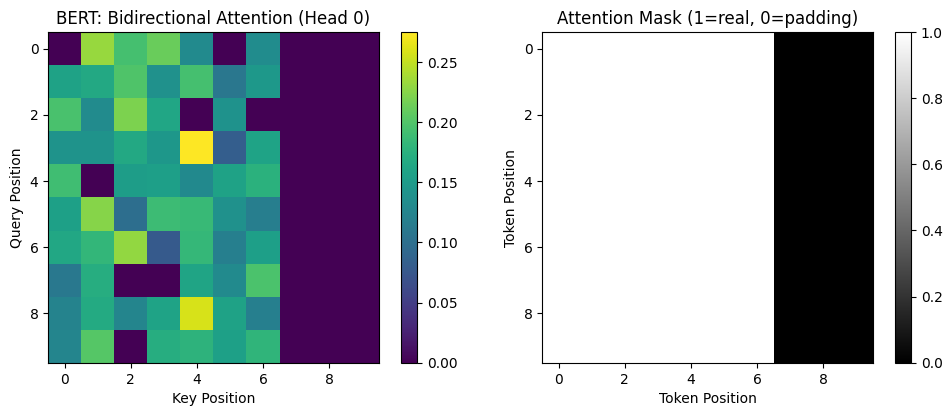

 GPU Memory - Allocated: 0.78GB, Cached: 0.94GB, Total: 4.2GB


(0.776632832, 0.939524096, 4.227465216)

In [24]:
class MultiHeadAttention(nn.Module):
    """
    Bidirectional Multi-Head Self-Attention for BERT.
    
    Args:
        d_model (int): Model dimension
        n_heads (int): Number of attention heads
        dropout (float): Dropout probability
    """
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        # Q, K, V projections
        self.w_q = nn.Linear(d_model, d_model, bias=True)
        self.w_k = nn.Linear(d_model, d_model, bias=True)
        self.w_v = nn.Linear(d_model, d_model, bias=True)
        
        # Output projection
        self.w_o = nn.Linear(d_model, d_model, bias=True)
        
        self.dropout = nn.Dropout(dropout)
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        """Initialize weights following BERT paper."""
        for module in [self.w_q, self.w_k, self.w_v, self.w_o]:
            nn.init.normal_(module.weight, mean=0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
    
    def forward(self, x, attention_mask=None):
        """
        Args:
            x: (batch_size, seq_len, d_model)
            attention_mask: (batch_size, seq_len) - 1 for real tokens, 0 for padding
        """
        batch_size, seq_len, d_model = x.shape
        
        # Linear projections
        Q = self.w_q(x)  # (B, L, d_model)
        K = self.w_k(x)
        V = self.w_v(x)
        
        # Reshape for multi-head attention
        Q = Q.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        # Now: (B, n_heads, L, d_k)
        
        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        # scores: (B, n_heads, L, L)
        
        # Apply attention mask (for padding)
        if attention_mask is not None:
            # Expand mask for all heads: (B, 1, 1, L)
            attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
            # Mask with large negative value
            scores = scores.masked_fill(attention_mask == 0, -1e9)
        
        # Softmax and dropout
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # Apply attention to values
        context = torch.matmul(attention_weights, V)  # (B, n_heads, L, d_k)
        
        # Concatenate heads
        context = context.transpose(1, 2).contiguous()
        context = context.view(batch_size, seq_len, d_model)
        
        # Output projection
        output = self.w_o(context)
        
        return output, attention_weights

# Test bidirectional attention
n_heads = 12  # BERT-Base uses 12 heads
attention = MultiHeadAttention(d_model, n_heads).to(device)

# Create sample input with padding
sample_input = torch.randn(2, 10, d_model).to(device)
# Attention mask: 1 for real tokens, 0 for padding
attention_mask = torch.ones(2, 10).to(device)
attention_mask[0, 7:] = 0  # Pad last 3 tokens of first sequence
attention_mask[1, 9:] = 0  # Pad last token of second sequence

attn_output, attn_weights = attention(sample_input, attention_mask)

print(f"   Multi-Head Attention Test:")
print(f"   Input: {sample_input.shape}")
print(f"   Attention mask: {attention_mask.shape}")
print(f"   Output: {attn_output.shape}")
print(f"   Attention weights: {attn_weights.shape}")
print(f"   Parameters: {sum(p.numel() for p in attention.parameters()):,}")

# Visualize attention pattern
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(attn_weights[0, 0].detach().cpu(), cmap='viridis')
plt.title('BERT: Bidirectional Attention (Head 0)')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(attention_mask[0].unsqueeze(0).repeat(10, 1).cpu(), cmap='gray')
plt.title('Attention Mask (1=real, 0=padding)')
plt.xlabel('Token Position')
plt.ylabel('Token Position')
plt.colorbar()
plt.tight_layout()
plt.show()

check_gpu_memory()

## ⚙️ Feed-Forward Network (FFN)

In BERT, each Transformer encoder block includes a **Position-wise Feed-Forward Network (FFN)** applied independently to each token’s hidden state.  
It is architecturally identical to GPT-2’s FFN, except that BERT uses the **GELU activation** instead of ReLU.

---

### 🧱 Architecture
$$
\begin{aligned}
&\text{Input } (d_{\text{model}} = 768) \\
&\downarrow \\
&\text{Linear (expand)} \rightarrow d_{\text{ff}} = 4 \times d_{\text{model}} = 3072 \\
&\downarrow \\
&\text{GELU activation} \\
&\downarrow \\
&\text{Linear (contract)} \rightarrow d_{\text{model}} = 768 \\
&\downarrow \\
&\text{Output}
\end{aligned}
$$

Formally, for hidden input $ h \in \mathbb{R}^{d_{\text{model}}} $:

$$
\text{FFN}(h) = W_2 \cdot \text{GELU}(W_1 h + b_1) + b_2
$$

where  
- $ W_1 \in \mathbb{R}^{d_{\text{ff}} \times d_{\text{model}}} $
- $ W_2 \in \mathbb{R}^{d_{\text{model}} \times d_{\text{ff}}} $ 
- Typically $ d_{\text{ff}} = 4 \times d_{\text{model}} $

---

### 🧮 GELU Activation

**Gaussian Error Linear Unit (GELU)** combines ideas from ReLU and dropout by weighting inputs according to their probability under a Gaussian distribution.

$$
\text{GELU}(x) = x \cdot \Phi(x) = x \cdot P(X \le x), \quad X \sim \mathcal{N}(0, 1)
$$

where $ \Phi(x) $ is the standard normal CDF.

**Approximation used in BERT (Hendrycks & Gimpel, 2016):**

$$
\text{GELU}(x) \approx 0.5x \left( 1 + \tanh\!\left[\sqrt{\frac{2}{\pi}}(x + 0.044715x^3)\right] \right)
$$

---

### 💡 Why BERT Uses GELU (vs. ReLU)

| Property | **ReLU** | **GELU** |
|-----------|-----------|-----------|
| Activation shape | Hard threshold at 0 | Smooth probabilistic gating |
| Derivative | Discontinuous at 0 | Smooth everywhere |
| Output for small negatives | 0 | Slightly negative (non-monotonic) |
| Effect | Sparse activations | Soft stochastic regularization |

**Advantages in BERT:**
- Provides **smoother gradient flow** during optimization  
- Introduces subtle nonlinearity beneficial for **semantic understanding**  
- Handles small negative activations gracefully → more stable training  

---

### 📘 Reference

- Hendrycks, D., & Gimpel, K. (2016). *Gaussian Error Linear Units (GELUs).* arXiv:1606.08415  
- Devlin, J., Chang, M.-W., Lee, K., & Toutanova, K. (2019). *BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding.* NAACL-HLT.  
  [https://arxiv.org/abs/1810.04805](https://arxiv.org/abs/1810.04805)

In [25]:
class FeedForward(nn.Module):
    """
    Position-wise Feed-Forward Network with GELU activation.
    
    Args:
        d_model (int): Model dimension
        d_ff (int): Feed-forward dimension (typically 4 * d_model)
        dropout (float): Dropout probability
    """
    def __init__(self, d_model, d_ff=None, dropout=0.1):
        super().__init__()
        if d_ff is None:
            d_ff = 4 * d_model
            
        self.linear1 = nn.Linear(d_model, d_ff)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        """Initialize weights following BERT paper."""
        nn.init.normal_(self.linear1.weight, mean=0, std=0.02)
        nn.init.normal_(self.linear2.weight, mean=0, std=0.02)
        nn.init.zeros_(self.linear1.bias)
        nn.init.zeros_(self.linear2.bias)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

# Test feed-forward network
d_ff = 4 * d_model  # 3072 for BERT-Base
ffn = FeedForward(d_model, d_ff).to(device)

sample_input = torch.randn(2, 10, d_model).to(device)
ffn_output = ffn(sample_input)

print(f"   Feed-Forward Network Test:")
print(f"   Input: {sample_input.shape}")
print(f"   Output: {ffn_output.shape}")
print(f"   Expansion: {d_model} → {d_ff} → {d_model}")
print(f"   Parameters: {sum(p.numel() for p in ffn.parameters()):,}")

   Feed-Forward Network Test:
   Input: torch.Size([2, 10, 768])
   Output: torch.Size([2, 10, 768])
   Expansion: 768 → 3072 → 768
   Parameters: 4,722,432


## Transformer Encoder Block

BERT uses the **encoder** portion of the original Transformer with **post-layer normalization** (unlike GPT-2's pre-norm).

### Architecture:

 BERT uses **post-norm**:


### Post-Norm vs Pre-Norm:
- **Post-norm** (BERT): Normalizes after residual addition
- **Pre-norm** (GPT-2): Normalizes before transformation
- Post-norm was standard in original Transformer paper
- Pre-norm became popular later for deeper models

### Mathematical Flow:
$ h1 = LayerNorm(x + MultiHeadAttention(x)) $

$ h2 = LayerNorm(h1 + FeedForward(h1)) $

In [26]:
class TransformerEncoderBlock(nn.Module):
    """
    Single BERT Transformer Encoder block with post-layer normalization.
    
    Args:
        d_model (int): Model dimension
        n_heads (int): Number of attention heads
        d_ff (int): Feed-forward dimension
        dropout (float): Dropout probability
    """
    def __init__(self, d_model, n_heads, d_ff=None, dropout=0.1):
        super().__init__()
        
        # Multi-head attention
        self.attention = MultiHeadAttention(d_model, n_heads, dropout)
        self.dropout1 = nn.Dropout(dropout)
        self.layer_norm1 = nn.LayerNorm(d_model, eps=1e-12)
        
        # Feed-forward network
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm2 = nn.LayerNorm(d_model, eps=1e-12)
        
    def forward(self, x, attention_mask=None):
        """
        Args:
            x: (batch_size, seq_len, d_model)
            attention_mask: (batch_size, seq_len)
        """
        # Multi-head attention with residual connection and layer norm
        attn_output, attn_weights = self.attention(x, attention_mask)
        attn_output = self.dropout1(attn_output)
        x = self.layer_norm1(x + attn_output)  # Post-norm
        
        # Feed-forward with residual connection and layer norm
        ff_output = self.feed_forward(x)
        ff_output = self.dropout2(ff_output)
        x = self.layer_norm2(x + ff_output)  # Post-norm
        
        return x, attn_weights

# Test encoder block
encoder_block = TransformerEncoderBlock(d_model, n_heads, d_ff).to(device)

sample_input = torch.randn(2, 10, d_model).to(device)
attention_mask = torch.ones(2, 10).to(device)
block_output, _ = encoder_block(sample_input, attention_mask)

print(f"   Transformer Encoder Block Test:")
print(f"   Input: {sample_input.shape}")
print(f"   Output: {block_output.shape}")
print(f"   Parameters: {sum(p.numel() for p in encoder_block.parameters()):,}")

check_gpu_memory()

   Transformer Encoder Block Test:
   Input: torch.Size([2, 10, 768])
   Output: torch.Size([2, 10, 768])
   Parameters: 7,087,872
 GPU Memory - Allocated: 0.78GB, Cached: 0.94GB, Total: 4.2GB


(0.776632832, 0.939524096, 4.227465216)

## Complete BERT Model

Now let's assemble the complete BERT model!

### 🧩 Full Architecture

$$
\begin{aligned}
&\text{Input Text} \\
&\downarrow \\
&[\text{Tokenization}] \;\rightarrow\; \text{Input IDs + Segment IDs} \\
&\downarrow \\
&\text{Embeddings (Token + Position + Segment)} \\
&\downarrow \\
&\text{Transformer Encoder} \times N \;\text{layers} \\
&\downarrow \\
&[\text{CLS}] \;\text{output} \;\rightarrow\; \text{Pooler} \;\rightarrow\; \text{Classification} \\
&\text{All tokens} \;\rightarrow\; \text{Token-level predictions (MLM, NER, QA, etc.)}
\end{aligned}
$$


### Key Components:
1. **Embedding Layer**: Token + Position + Segment
2. **Encoder Stack**: 12 layers for Base, 24 for Large
3. **Pooler**: Dense layer on [CLS] for classification
4. **MLM Head**: Predicts masked tokens
5. **NSP Head**: Predicts if sentence B follows A

### Model Sizes:
- **BERT-Base**: 110M parameters (~440MB)
- **BERT-Large**: 340M parameters (~1.3GB)
- **BERT-Tiny** (for testing): 4.4M parameters

In [27]:
class BERTModel(nn.Module):
    """
    Complete BERT model implementation.
    
    Args:
        vocab_size (int): Vocabulary size
        d_model (int): Model dimension
        n_heads (int): Number of attention heads
        n_layers (int): Number of encoder layers
        d_ff (int): Feed-forward dimension
        max_seq_len (int): Maximum sequence length
        dropout (float): Dropout probability
    """
    def __init__(self, vocab_size, d_model, n_heads, n_layers, d_ff=None, max_seq_len=512, dropout=0.1):
        super().__init__()
        
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        
        # Embeddings
        self.embedding = BERTEmbedding(vocab_size, d_model, max_seq_len, dropout)
        
        # Transformer encoder blocks
        self.encoder_blocks = nn.ModuleList([
            TransformerEncoderBlock(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])
        
        # Pooler for [CLS] token (used in classification tasks)
        self.pooler = nn.Linear(d_model, d_model)
        self.pooler_activation = nn.Tanh()
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        """Initialize pooler weights."""
        nn.init.normal_(self.pooler.weight, mean=0, std=0.02)
        nn.init.zeros_(self.pooler.bias)
        
    def forward(self, input_ids, segment_ids=None, attention_mask=None):
        """
        Args:
            input_ids: (batch_size, seq_len)
            segment_ids: (batch_size, seq_len) - optional
            attention_mask: (batch_size, seq_len) - optional
        
        Returns:
            sequence_output: (batch_size, seq_len, d_model)
            pooled_output: (batch_size, d_model)
        """
        batch_size, seq_len = input_ids.shape
        
        # Create attention mask if not provided
        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)
        
        # Embeddings
        x = self.embedding(input_ids, segment_ids)
        
        # Pass through encoder blocks
        attention_weights_list = []
        for encoder_block in self.encoder_blocks:
            x, attn_weights = encoder_block(x, attention_mask)
            attention_weights_list.append(attn_weights)
        
        # Sequence output (all tokens)
        sequence_output = x
        
        # Pooled output (only [CLS] token)
        cls_output = x[:, 0, :]  # Take first token ([CLS])
        pooled_output = self.pooler_activation(self.pooler(cls_output))
        
        return sequence_output, pooled_output, attention_weights_list

# BERT-Base configuration (fits well on T4)
config_base = {
    'vocab_size': 30522,
    'd_model': 768,
    'n_heads': 12,
    'n_layers': 12,
    'd_ff': 3072,
    'max_seq_len': 512,
    'dropout': 0.1
}

# Create BERT-Tiny for quick testing
config_tiny = {
    'vocab_size': 30522,
    'd_model': 128,
    'n_heads': 2,
    'n_layers': 2,
    'd_ff': 512,
    'max_seq_len': 512,
    'dropout': 0.1
}

print(" Creating BERT models...")

# Create BERT-Tiny for testing
bert_tiny = BERTModel(**config_tiny).to(device)
tiny_stats = get_model_size(bert_tiny)
print(f"\n BERT-Tiny created!")
print(f"   Parameters: {tiny_stats['parameters']:,}")
print(f"   Size: {tiny_stats['size_mb']:.1f}MB")

# Create BERT-Base (comment out if memory constrained)
bert_base = BERTModel(**config_base).to(device)
base_stats = get_model_size(bert_base)
print(f"\n BERT-Base created!")
print(f"   Parameters: {base_stats['parameters']:,}")
print(f"   Size: {base_stats['size_mb']:.1f}MB ({base_stats['size_gb']:.2f}GB)")

# Test forward pass
test_input_ids = torch.randint(100, 30000, (2, 20)).to(device)
test_segment_ids = torch.cat([
    torch.zeros(2, 10, dtype=torch.long),
    torch.ones(2, 10, dtype=torch.long)
], dim=1).to(device)
test_mask = torch.ones(2, 20).to(device)

with torch.no_grad():
    seq_output, pooled_output, attn_weights = bert_base(
        test_input_ids, test_segment_ids, test_mask
    )

print(f"\n  Forward pass test:")
print(f"   Input IDs: {test_input_ids.shape}")
print(f"   Sequence output: {seq_output.shape}")
print(f"   Pooled output (CLS): {pooled_output.shape}")
print(f"   Attention layers: {len(attn_weights)}")

# Memory check
check_gpu_memory()

 Creating BERT models...

 BERT-Tiny created!
   Parameters: 4,385,920
   Size: 17.5MB

 BERT-Base created!
   Parameters: 109,482,240
   Size: 437.9MB (0.44GB)

  Forward pass test:
   Input IDs: torch.Size([2, 20])
   Sequence output: torch.Size([2, 20, 768])
   Pooled output (CLS): torch.Size([2, 768])
   Attention layers: 12
 GPU Memory - Allocated: 1.23GB, Cached: 1.31GB, Total: 4.2GB


(1.234421248, 1.31072, 4.227465216)

## Pre-training Tasks

BERT is pre-trained on two tasks simultaneously:

### 1. Masked Language Modeling (MLM)
- **Goal**: Predict masked tokens using bidirectional context
- **Process**: Randomly mask 15% of tokens
  - 80% replaced with [MASK]
  - 10% replaced with random token
  - 10% kept unchanged
- **Why this strategy?**: Prevents model from learning that [MASK] only appears during training

### 2. Next Sentence Prediction (NSP)
- **Goal**: Predict if sentence B follows sentence A
- **Process**: 50% positive pairs, 50% negative pairs
- **Use case**: Improves performance on QA and NLI tasks

### Mathematical Formulation:

### 🧮 BERT Training Objectives

**Masked Language Modeling (MLM) Loss:**

$$
\mathcal{L}_{\text{MLM}} = -\frac{1}{|M|} \sum_{i \in M} \log P\big(x_i \mid x_{\setminus M}\big)
$$

where  
- $ M $ = set of masked token positions  
- $ x_i $ = true token at position $ i $ 
- $ x_{\setminus M} $ = input sequence with masked tokens  

---

**Next Sentence Prediction (NSP) Loss:**

$$
\mathcal{L}_{\text{NSP}} = - \log P(\text{IsNext} \mid h_{\text{[CLS]}})
$$

where  
- $ h_{\text{[CLS]}} $ = representation of the [CLS] token from the final encoder layer  

---

**Total Training Loss:**

$$
\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{MLM}} + \mathcal{L}_{\text{NSP}}
$$


In [28]:
class BERTForPreTraining(nn.Module):
    """
    BERT with MLM and NSP heads for pre-training.
    
    Args:
        bert_model: Base BERT model
        vocab_size: Vocabulary size
    """
    def __init__(self, bert_model, vocab_size):
        super().__init__()
        
        self.bert = bert_model
        d_model = bert_model.d_model
        
        # MLM Head (predicts masked tokens)
        self.mlm_head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.LayerNorm(d_model, eps=1e-12),
            nn.Linear(d_model, vocab_size)
        )
        
        # NSP Head (predicts if sentence B follows A)
        self.nsp_head = nn.Linear(d_model, 2)  # Binary classification
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        """Initialize head weights."""
        for module in self.mlm_head:
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0, std=0.02)
                nn.init.zeros_(module.bias)
        
        nn.init.normal_(self.nsp_head.weight, mean=0, std=0.02)
        nn.init.zeros_(self.nsp_head.bias)
        
    def forward(self, input_ids, segment_ids=None, attention_mask=None):
        """
        Args:
            input_ids: (batch_size, seq_len)
            segment_ids: (batch_size, seq_len)
            attention_mask: (batch_size, seq_len)
        
        Returns:
            mlm_logits: (batch_size, seq_len, vocab_size)
            nsp_logits: (batch_size, 2)
        """
        # Get BERT outputs
        sequence_output, pooled_output, _ = self.bert(
            input_ids, segment_ids, attention_mask
        )
        
        # MLM predictions for all tokens
        mlm_logits = self.mlm_head(sequence_output)
        
        # NSP prediction from [CLS] token
        nsp_logits = self.nsp_head(pooled_output)
        
        return mlm_logits, nsp_logits

# Create pre-training model
bert_pretrain = BERTForPreTraining(bert_base, config_base['vocab_size']).to(device)

print("   BERT Pre-training Model created!")
print(f"   Total parameters: {sum(p.numel() for p in bert_pretrain.parameters()):,}")

# Test pre-training forward pass
with torch.no_grad():
    mlm_logits, nsp_logits = bert_pretrain(
        test_input_ids, test_segment_ids, test_mask
    )

print(f"\n   MLM logits: {mlm_logits.shape}")
print(f"   NSP logits: {nsp_logits.shape}")

   BERT Pre-training Model created!
   Total parameters: 133,547,324

   MLM logits: torch.Size([2, 20, 30522])
   NSP logits: torch.Size([2, 2])


## Masked Language Modeling (MLM) Implementation

Let's implement the masking strategy and training for MLM.

### Masking Strategy:
For each selected token:
- 80% chance: Replace with [MASK] token
- 10% chance: Replace with random token
- 10% chance: Keep original token

### Why this complexity?
- **[MASK] doesn't appear in fine-tuning**: Model must learn robust representations
- **Random tokens**: Prevents overfitting to specific patterns
- **Original tokens**: Model learns to refine representations

### Special Tokens:
- [PAD] = 0
- [CLS] = 101
- [SEP] = 102
- [MASK] = 103

  MLM Masking Test:
   Original tokens: [101, 19749, 9834, 23774, 27982, 15580, 23098, 12021, 13866, 26658, 102, 19625, 948, 1104, 14391]
   Masked tokens:   [101, 103, 9834, 23774, 103, 15580, 23098, 12021, 13866, 26658, 102, 19625, 948, 1104, 14391]
   Masked positions: [4, 1]
   Number masked: 2 / 20 (10.0%)


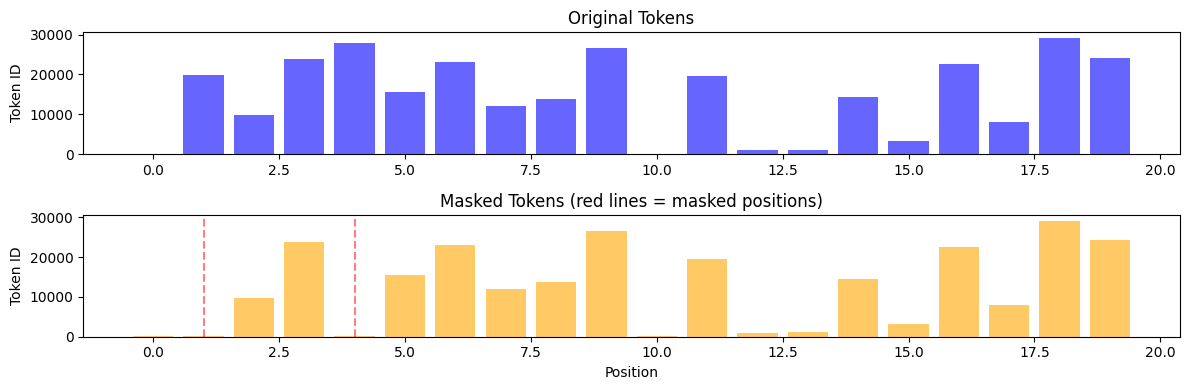

In [29]:
class MLMDataset:
    """
    Creates MLM training data from raw token sequences.
    """
    def __init__(self, vocab_size, mask_prob=0.15, mask_token_id=103):
        self.vocab_size = vocab_size
        self.mask_prob = mask_prob
        self.mask_token_id = mask_token_id
        self.special_tokens = {0, 101, 102, 103}  # [PAD], [CLS], [SEP], [MASK]
        
    def create_masked_lm_predictions(self, tokens):
        """
        Create masked LM predictions for a sequence.
        
        Args:
            tokens: (seq_len,) tensor of token IDs
        
        Returns:
            masked_tokens: tokens with masking applied
            masked_positions: positions that were masked
            masked_labels: original tokens at masked positions
        """
        seq_len = tokens.size(0)
        masked_tokens = tokens.clone()
        
        # Don't mask special tokens
        candidate_positions = [i for i in range(seq_len) 
                              if tokens[i].item() not in self.special_tokens]
        
        # Select 15% of positions to mask
        n_masked = max(1, int(len(candidate_positions) * self.mask_prob))
        masked_positions = random.sample(candidate_positions, n_masked)
        
        masked_labels = torch.zeros(seq_len, dtype=torch.long) - 100  # -100 = ignore in loss
        
        for pos in masked_positions:
            masked_labels[pos] = tokens[pos].item()
            
            prob = random.random()
            if prob < 0.8:
                # 80% of the time, replace with [MASK]
                masked_tokens[pos] = self.mask_token_id
            elif prob < 0.9:
                # 10% of the time, replace with random token
                masked_tokens[pos] = random.randint(1, self.vocab_size - 1)
            # else: 10% of the time, keep original
        
        return masked_tokens, torch.tensor(masked_positions), masked_labels

# Test MLM masking
mlm_dataset = MLMDataset(config_base['vocab_size'])

sample_tokens = torch.randint(104, 30000, (20,))
sample_tokens[0] = 101  # [CLS]
sample_tokens[10] = 102  # [SEP]

masked_tokens, masked_pos, masked_labels = mlm_dataset.create_masked_lm_predictions(sample_tokens)

print("  MLM Masking Test:")
print(f"   Original tokens: {sample_tokens[:15].tolist()}")
print(f"   Masked tokens:   {masked_tokens[:15].tolist()}")
print(f"   Masked positions: {masked_pos.tolist()}")
print(f"   Number masked: {len(masked_pos)} / {len(sample_tokens)} ({len(masked_pos)/len(sample_tokens)*100:.1f}%)")

# Visualize masking
fig, axes = plt.subplots(2, 1, figsize=(12, 4))

axes[0].bar(range(len(sample_tokens)), sample_tokens.numpy(), color='blue', alpha=0.6)
axes[0].set_title('Original Tokens')
axes[0].set_ylabel('Token ID')

axes[1].bar(range(len(masked_tokens)), masked_tokens.numpy(), color='orange', alpha=0.6)
for pos in masked_pos:
    axes[1].axvline(x=pos, color='red', linestyle='--', alpha=0.5)
axes[1].set_title('Masked Tokens (red lines = masked positions)')
axes[1].set_xlabel('Position')
axes[1].set_ylabel('Token ID')

plt.tight_layout()
plt.show()

## Training Loop for Pre-training

Let's implement a training loop for BERT pre-training with both MLM and NSP tasks.

### Training Strategy:
1. **MLM Loss**: Cross-entropy on masked positions only
2. **NSP Loss**: Binary cross-entropy on sentence pair classification
3. **Total Loss**: Sum of both losses
4. **Optimization**: AdamW with learning rate warmup

### 🔺 Learning Rate Schedule (Linear Warmup + Decay)

$$
\text{lr}(t) = \text{lr}_{\text{max}} \times 
\min \left( 
\frac{t}{\text{warmup}}, \;
\frac{\text{total\_steps} - t}{\text{total\_steps} - \text{warmup}}
\right)
$$

where  
- $ t $ = current training step  
- $ \text{warmup} $ = number of warmup steps  
- $ \text{total\_steps} $ = total training steps  
- $ \text{lr}_{\text{max}} $ = peak learning rate  

---

**Explanation:**
- During the **warmup phase** $ (t < \text{warmup}) $, learning rate increases linearly from 0 → $ \text{lr}_{\text{max}} $.  
- After warmup, it **decays linearly** back toward 0 over the remaining steps.  
- This schedule helps stabilize early training and prevents divergence in large-batch optimization (common in BERT pretraining).


### Hyperparameters (BERT paper):
- Batch size: 256 sequences
- Max seq length: 512 tokens
- Learning rate: 1e-4
- Warmup steps: 10,000
- Training steps: 1,000,000

In [ ]:
from torch.cuda.amp import autocast, GradScaler

def train_bert_pretrain(model, dataloader, num_steps=100, learning_rate=1e-4, warmup_steps=10):
    """
    Training loop for BERT pre-training.
    
    Args:
        model: BERT pre-training model
        dataloader: Training data loader
        num_steps: Number of training steps
        learning_rate: Peak learning rate
        warmup_steps: Number of warmup steps
    """
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, 
                                   betas=(0.9, 0.999), weight_decay=0.01)
    scaler = GradScaler()  # For mixed precision
    
    # Loss functions
    mlm_criterion = nn.CrossEntropyLoss(ignore_index=-100)  # Ignore non-masked tokens
    nsp_criterion = nn.CrossEntropyLoss()
    
    losses_mlm = []
    losses_nsp = []
    losses_total = []
    
    step = 0
    print("  Starting BERT pre-training...")
    print("=" * 60)
    
    for epoch in range(100):  # Arbitrary large number
        for batch_idx, batch in enumerate(dataloader):
            if step >= num_steps:
                break
                
            # Learning rate warmup
            if step < warmup_steps:
                lr_scale = (step + 1) / warmup_steps
            else:
                lr_scale = 1.0
            
            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate * lr_scale
            
            # Unpack batch
            input_ids = batch[0].to(device)
            segment_ids = batch[1].to(device)
            attention_mask = batch[2].to(device)
            mlm_labels = batch[3].to(device)
            nsp_labels = batch[4].to(device)
            
            optimizer.zero_grad()
            
            # Mixed precision forward pass
            with autocast():
                mlm_logits, nsp_logits = model(input_ids, segment_ids, attention_mask)
                
                # Compute losses
                mlm_loss = mlm_criterion(mlm_logits.view(-1, mlm_logits.size(-1)), 
                                         mlm_labels.view(-1))
                nsp_loss = nsp_criterion(nsp_logits, nsp_labels)
                total_loss = mlm_loss + nsp_loss
            
            # Backward pass with gradient scaling
            scaler.scale(total_loss).backward()
            scaler.unscale_(optimizer)
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            scaler.step(optimizer)
            scaler.update()
            
            # Record losses
            losses_mlm.append(mlm_loss.item())
            losses_nsp.append(nsp_loss.item())
            losses_total.append(total_loss.item())
            
            if step % 10 == 0:
                print(f"Step {step:3d} | LR: {optimizer.param_groups[0]['lr']:.6f} | "
                      f"MLM: {mlm_loss.item():.4f} | NSP: {nsp_loss.item():.4f} | "
                      f"Total: {total_loss.item():.4f}")
            
            step += 1
            
        if step >= num_steps:
            break
    
    print("=" * 60)
    print(f"   Training completed!")
    print(f"   Final MLM loss: {losses_mlm[-1]:.4f}")
    print(f"   Final NSP loss: {losses_nsp[-1]:.4f}")
    print(f"   Final Total loss: {losses_total[-1]:.4f}")
    
    return losses_mlm, losses_nsp, losses_total

# Create dummy pre-training dataset
def create_pretraining_data(vocab_size, num_samples=100, seq_len=64):
    """Create dummy pre-training data."""
    mlm_dataset_helper = MLMDataset(vocab_size)
    
    input_ids_list = []
    segment_ids_list = []
    attention_mask_list = []
    mlm_labels_list = []
    nsp_labels_list = []
    
    for _ in range(num_samples):
        # Generate random sequence
        seq = torch.randint(104, vocab_size, (seq_len,))
        seq[0] = 101  # [CLS]
        
        # Random split for two sentences
        split_point = random.randint(seq_len // 3, 2 * seq_len // 3)
        seq[split_point] = 102  # [SEP]
        
        # Segment IDs
        segment_ids = torch.cat([
            torch.zeros(split_point + 1, dtype=torch.long),
            torch.ones(seq_len - split_point - 1, dtype=torch.long)
        ])
        
        # Attention mask (all 1s for this dummy data)
        attention_mask = torch.ones(seq_len)
        
        # Apply MLM masking
        masked_seq, _, mlm_labels = mlm_dataset_helper.create_masked_lm_predictions(seq)
        
        # NSP label (random for dummy data)
        nsp_label = random.randint(0, 1)
        
        input_ids_list.append(masked_seq)
        segment_ids_list.append(segment_ids)
        attention_mask_list.append(attention_mask)
        mlm_labels_list.append(mlm_labels)
        nsp_labels_list.append(nsp_label)
    
    return TensorDataset(
        torch.stack(input_ids_list),
        torch.stack(segment_ids_list),
        torch.stack(attention_mask_list),
        torch.stack(mlm_labels_list),
        torch.tensor(nsp_labels_list, dtype=torch.long)
    )

# Create training data and dataloader
print("  Creating pre-training dataset...")
pretrain_dataset = create_pretraining_data(config_tiny['vocab_size'], num_samples=200, seq_len=64)
pretrain_loader = DataLoader(pretrain_dataset, batch_size=8, shuffle=True)

print(f"   Dataset size: {len(pretrain_dataset)} samples")
print(f"   Batch size: 8")

# Train BERT-Tiny for demonstration
bert_tiny_pretrain = BERTForPreTraining(bert_tiny, config_tiny['vocab_size']).to(device)

losses_mlm, losses_nsp, losses_total = train_bert_pretrain(
    bert_tiny_pretrain, 
    pretrain_loader, 
    num_steps=50,
    learning_rate=1e-4,
    warmup_steps=5
)

# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(losses_mlm, 'b-', linewidth=2)
axes[0].set_title('MLM Loss')
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Loss')
axes[0].grid(True, alpha=0.3)

axes[1].plot(losses_nsp, 'g-', linewidth=2)
axes[1].set_title('NSP Loss')
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Loss')
axes[1].grid(True, alpha=0.3)

axes[2].plot(losses_total, 'r-', linewidth=2)
axes[2].set_title('Total Loss')
axes[2].set_xlabel('Step')
axes[2].set_ylabel('Loss')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

check_gpu_memory()

## Fine-tuning for Downstream Tasks

After pre-training, BERT can be fine-tuned for specific tasks by adding task-specific heads.

### Common Fine-tuning Tasks:

1. **Sequence Classification** (Sentiment, Topic, etc.)
   - Use [CLS] token representation
   - Add linear classifier on top

2. **Token Classification** (NER, POS tagging)
   - Use all token representations
   - Add linear classifier for each token

3. **Question Answering** (SQuAD)
   - Predict start and end positions
   - Two separate linear layers

4. **Sentence Pair Classification** (NLI, Paraphrase)
   - Use [CLS] token representation
   - Input format: [CLS] Sentence A [SEP] Sentence B [SEP]

### Fine-tuning vs Pre-training:
- **Learning rate**: Much smaller (2e-5 to 5e-5)
- **Epochs**: Few (2-4 typically)
- **Batch size**: Smaller (16-32)
- **All parameters**: Fine-tune entire model, not just head

In [30]:
class BERTForSequenceClassification(nn.Module):
    """
    BERT for sequence classification (sentiment, topic, etc.)
    
    Args:
        bert_model: Pre-trained BERT model
        num_classes: Number of classes
        dropout: Dropout probability
    """
    def __init__(self, bert_model, num_classes, dropout=0.1):
        super().__init__()
        
        self.bert = bert_model
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(bert_model.d_model, num_classes)
        
        # Initialize classifier
        nn.init.normal_(self.classifier.weight, mean=0, std=0.02)
        nn.init.zeros_(self.classifier.bias)
        
    def forward(self, input_ids, segment_ids=None, attention_mask=None):
        """
        Args:
            input_ids: (batch_size, seq_len)
            segment_ids: (batch_size, seq_len)
            attention_mask: (batch_size, seq_len)
        
        Returns:
            logits: (batch_size, num_classes)
        """
        # Get BERT outputs
        _, pooled_output, _ = self.bert(input_ids, segment_ids, attention_mask)
        
        # Apply dropout and classifier
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        return logits

class BERTForTokenClassification(nn.Module):
    """
    BERT for token classification (NER, POS tagging, etc.)
    
    Args:
        bert_model: Pre-trained BERT model
        num_labels: Number of labels per token
        dropout: Dropout probability
    """
    def __init__(self, bert_model, num_labels, dropout=0.1):
        super().__init__()
        
        self.bert = bert_model
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(bert_model.d_model, num_labels)
        
        # Initialize classifier
        nn.init.normal_(self.classifier.weight, mean=0, std=0.02)
        nn.init.zeros_(self.classifier.bias)
        
    def forward(self, input_ids, segment_ids=None, attention_mask=None):
        """
        Args:
            input_ids: (batch_size, seq_len)
            segment_ids: (batch_size, seq_len)
            attention_mask: (batch_size, seq_len)
        
        Returns:
            logits: (batch_size, seq_len, num_labels)
        """
        # Get BERT outputs
        sequence_output, _, _ = self.bert(input_ids, segment_ids, attention_mask)
        
        # Apply dropout and classifier to all tokens
        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)
        
        return logits

# Create fine-tuning models
num_classes = 5  # e.g., 5-way sentiment classification
num_labels = 9   # e.g., NER with 9 entity types

bert_classifier = BERTForSequenceClassification(bert_tiny, num_classes).to(device)
bert_token_classifier = BERTForTokenClassification(bert_tiny, num_labels).to(device)

print("  Fine-tuning Models created!")
print(f"\n   Sequence Classification:")
print(f"      Parameters: {sum(p.numel() for p in bert_classifier.parameters()):,}")

print(f"\n   Token Classification:")
print(f"      Parameters: {sum(p.numel() for p in bert_token_classifier.parameters()):,}")

# Test fine-tuning forward passes
test_input = torch.randint(104, 30000, (4, 32)).to(device)
test_mask = torch.ones(4, 32).to(device)

with torch.no_grad():
    # Sequence classification
    seq_logits = bert_classifier(test_input, attention_mask=test_mask)
    print(f"\n   Sequence classification output: {seq_logits.shape}")
    
    # Token classification
    token_logits = bert_token_classifier(test_input, attention_mask=test_mask)
    print(f"   Token classification output: {token_logits.shape}")

  Fine-tuning Models created!

   Sequence Classification:
      Parameters: 4,386,565

   Token Classification:
      Parameters: 4,387,081

   Sequence classification output: torch.Size([4, 5])
   Token classification output: torch.Size([4, 32, 9])
